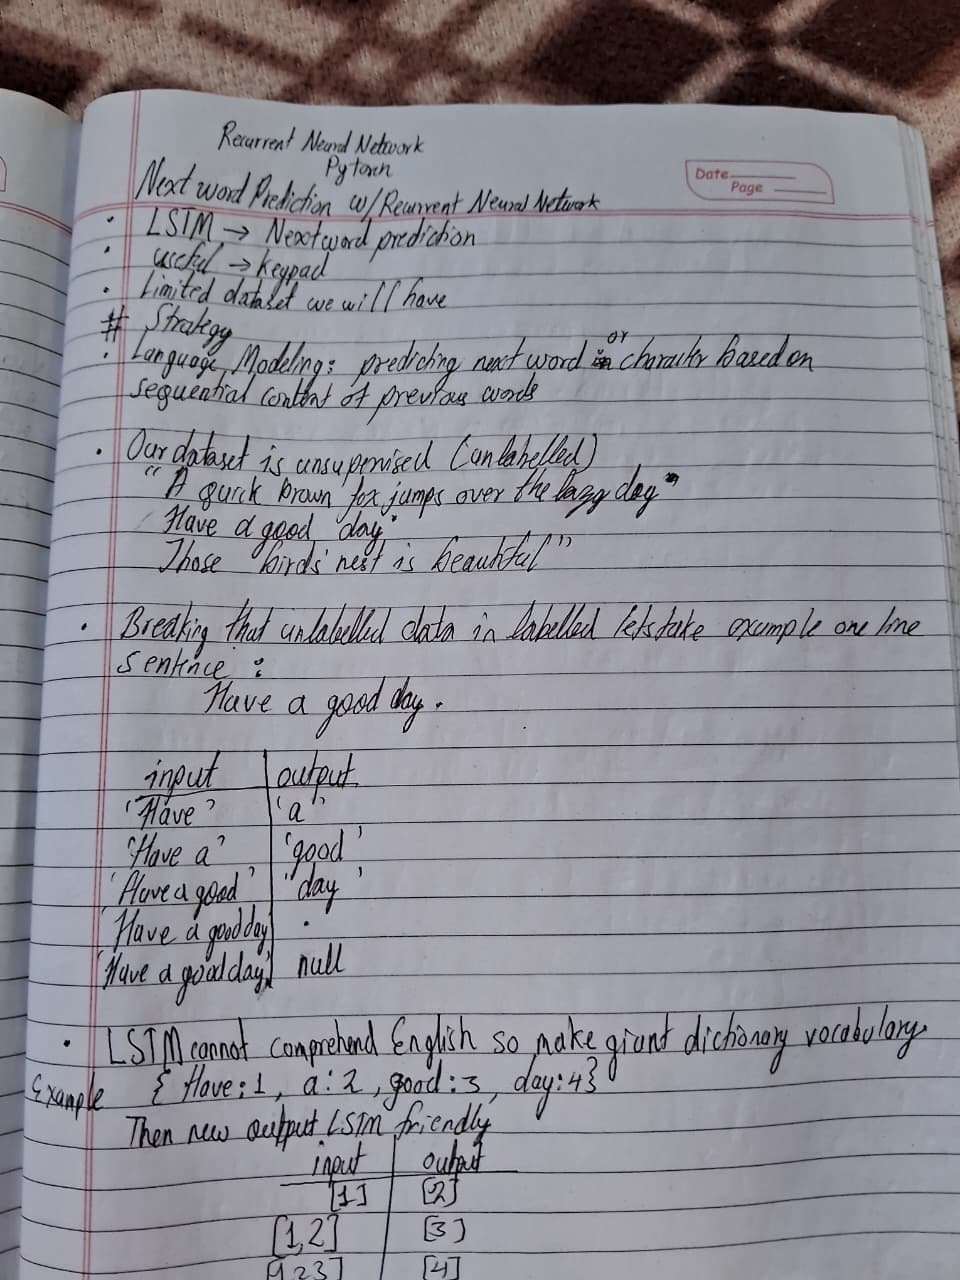


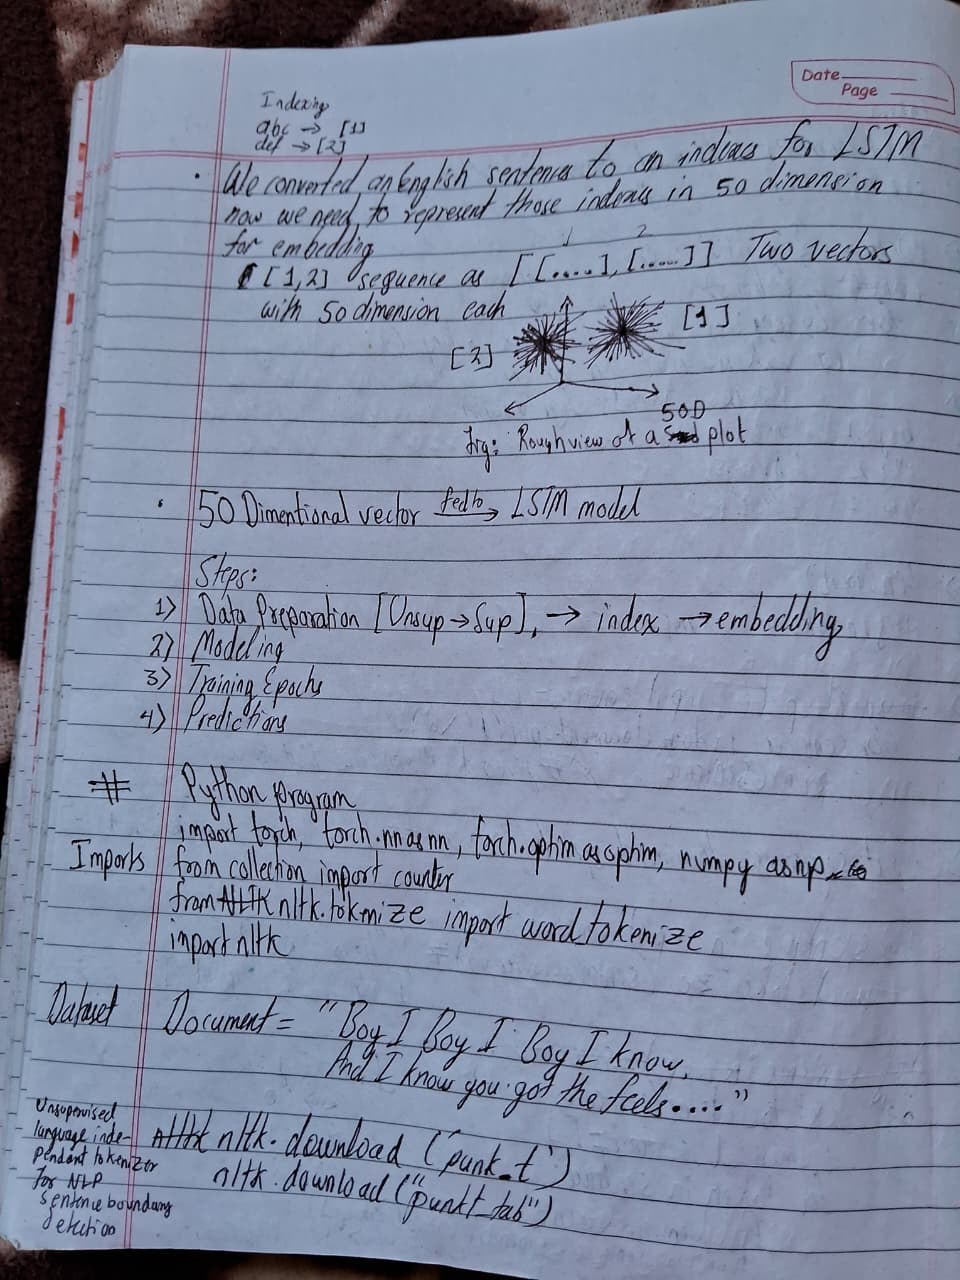




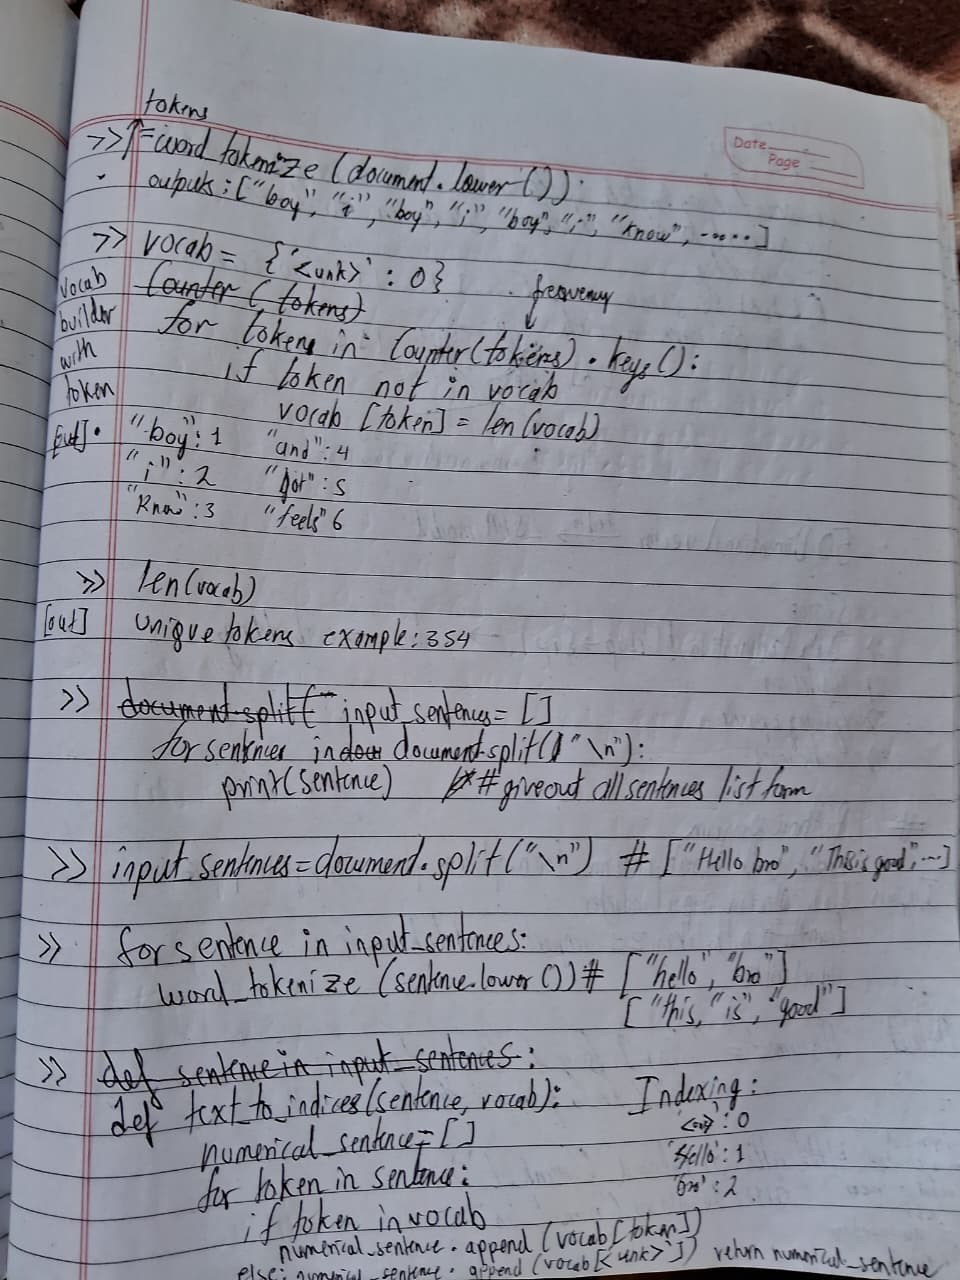



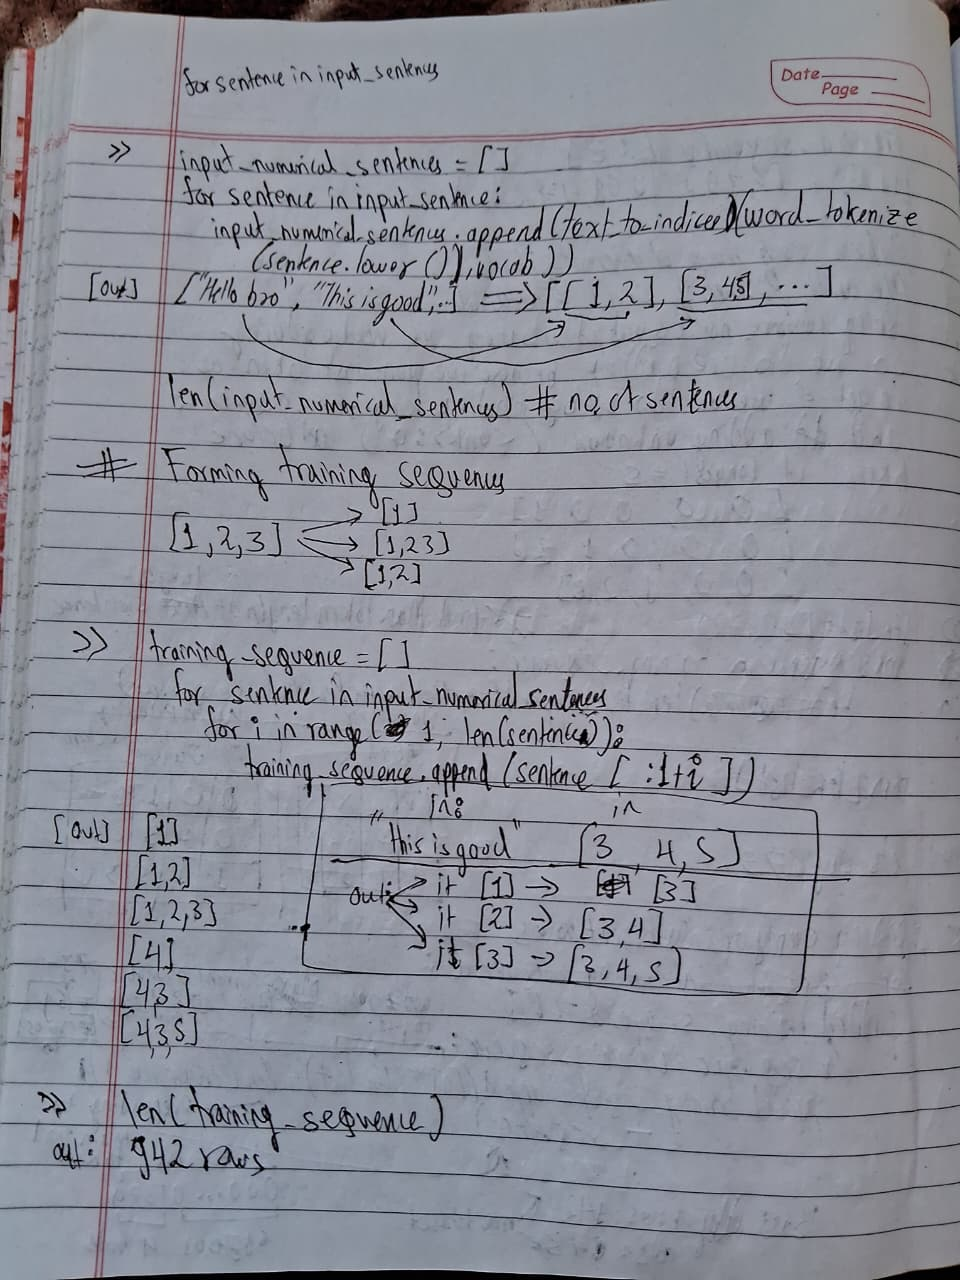


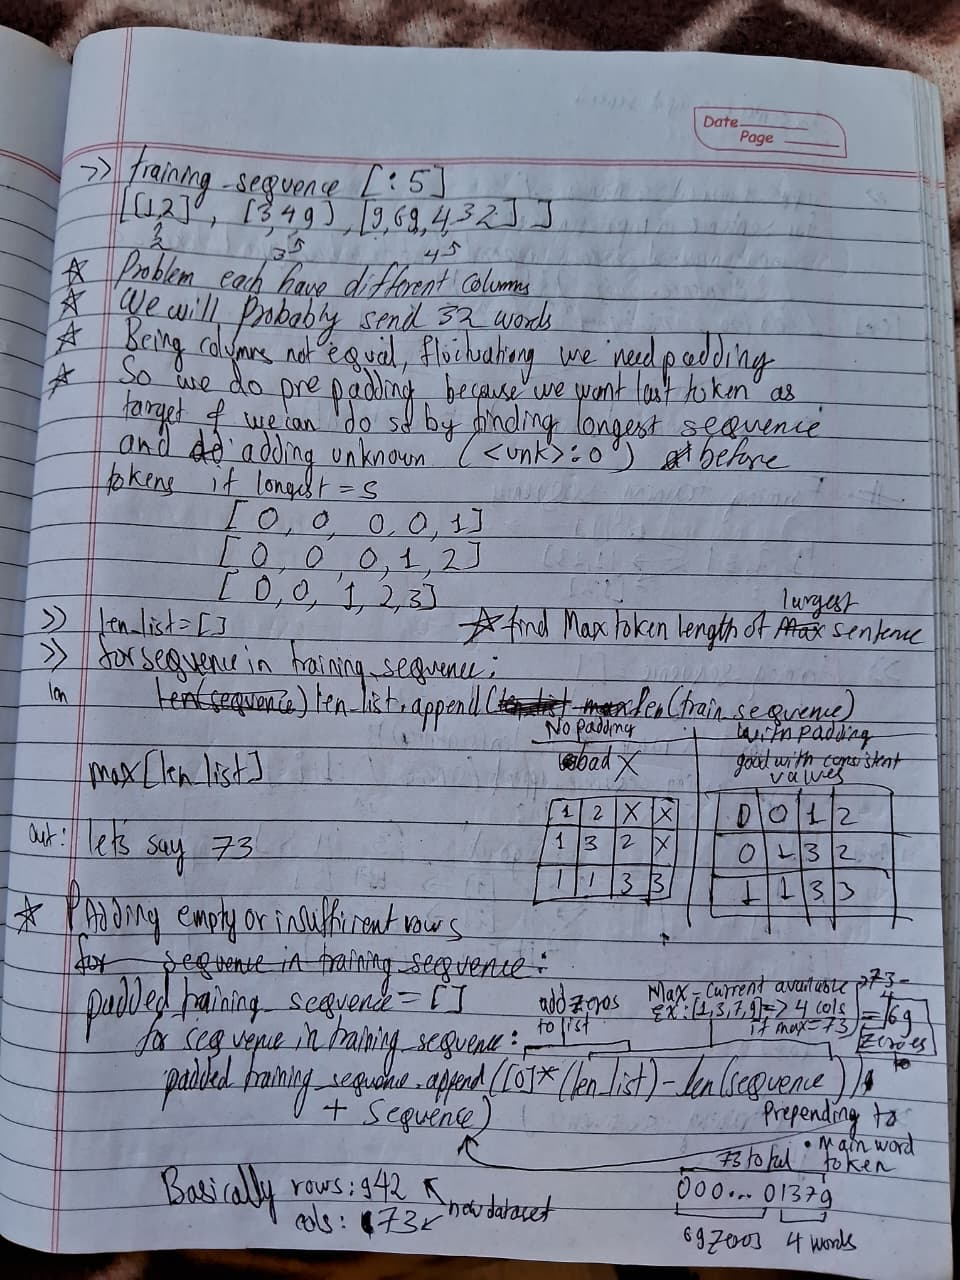


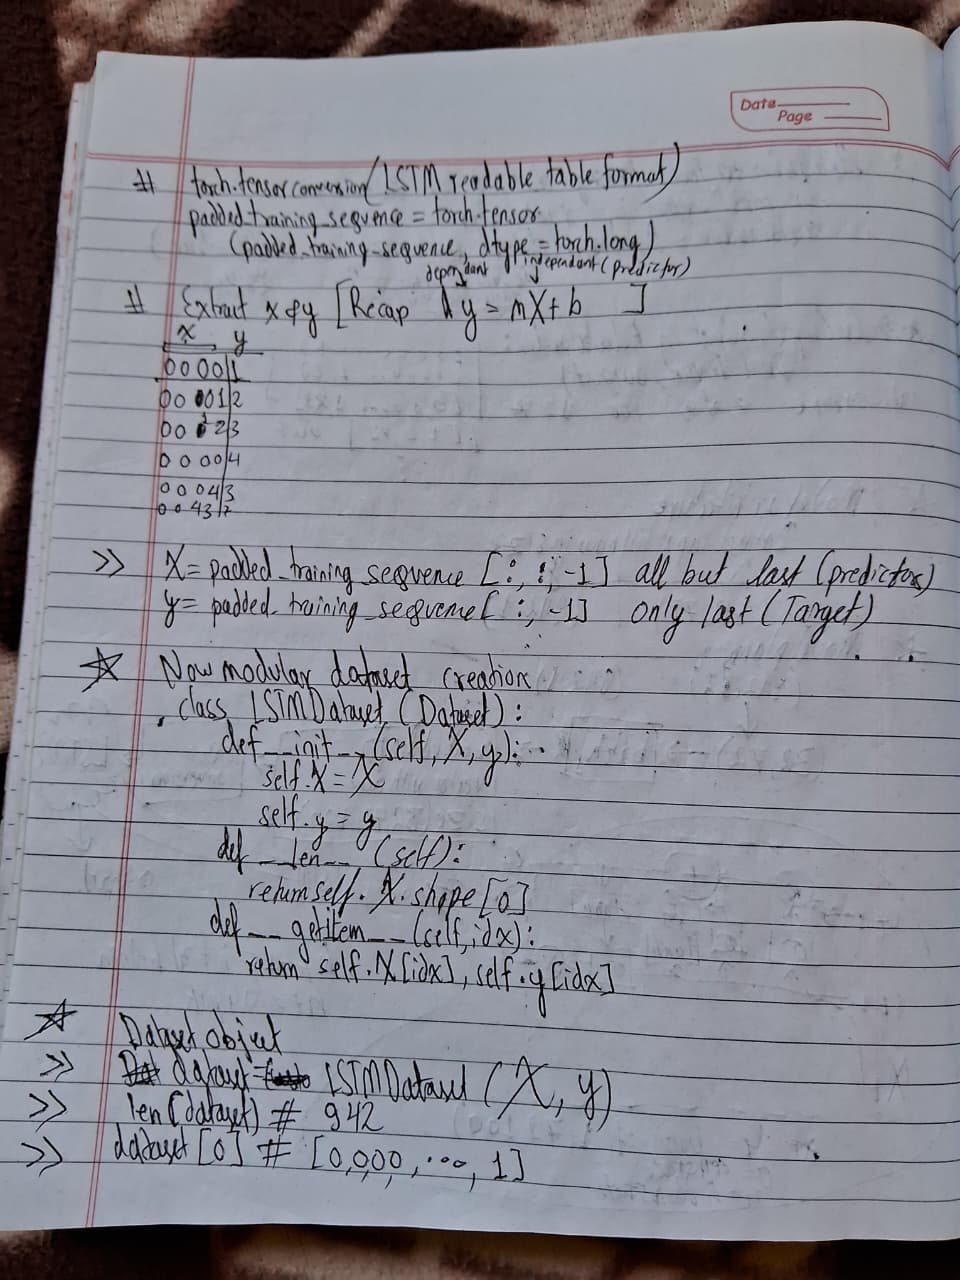

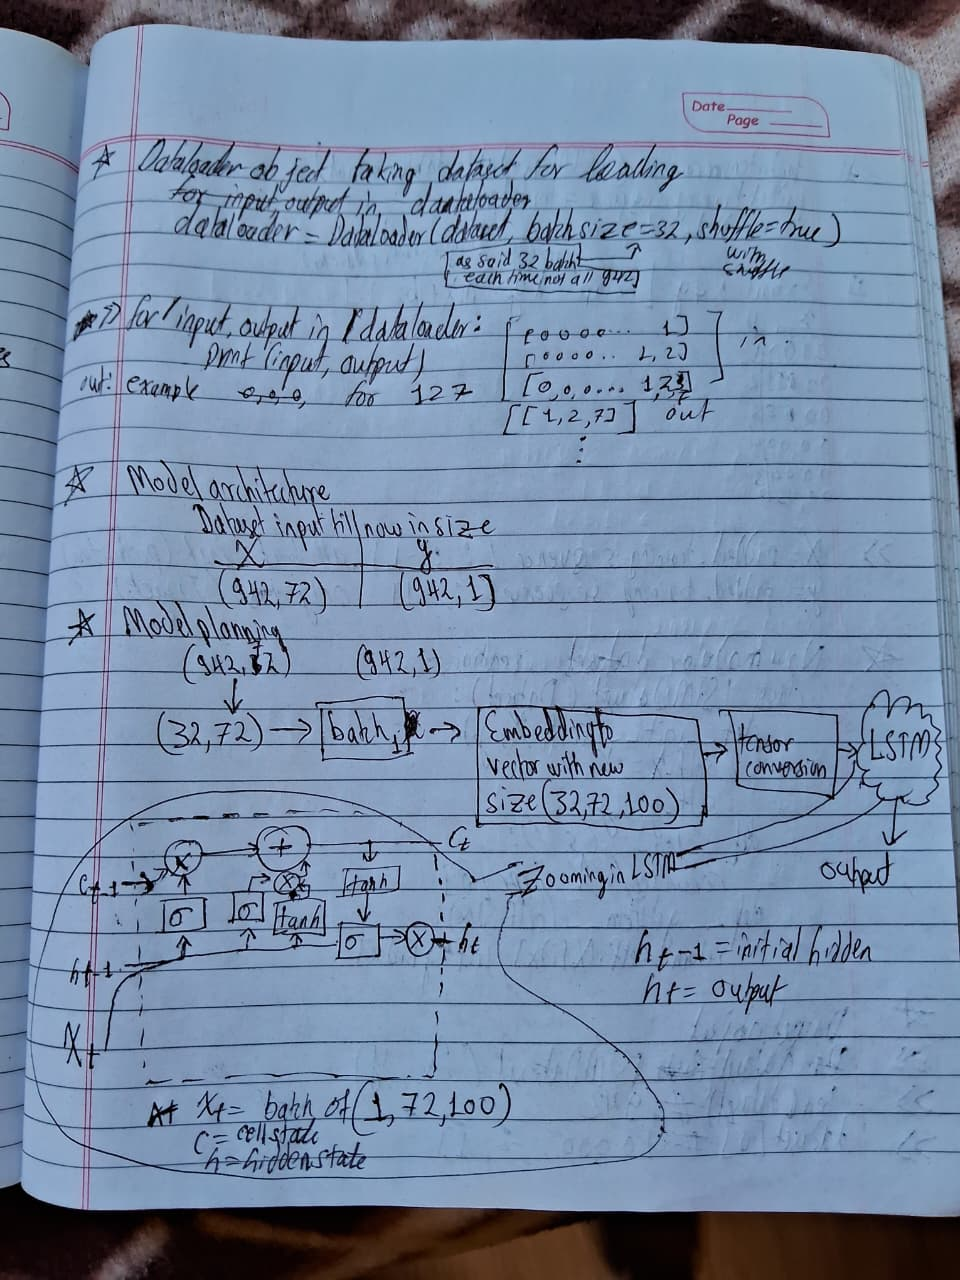

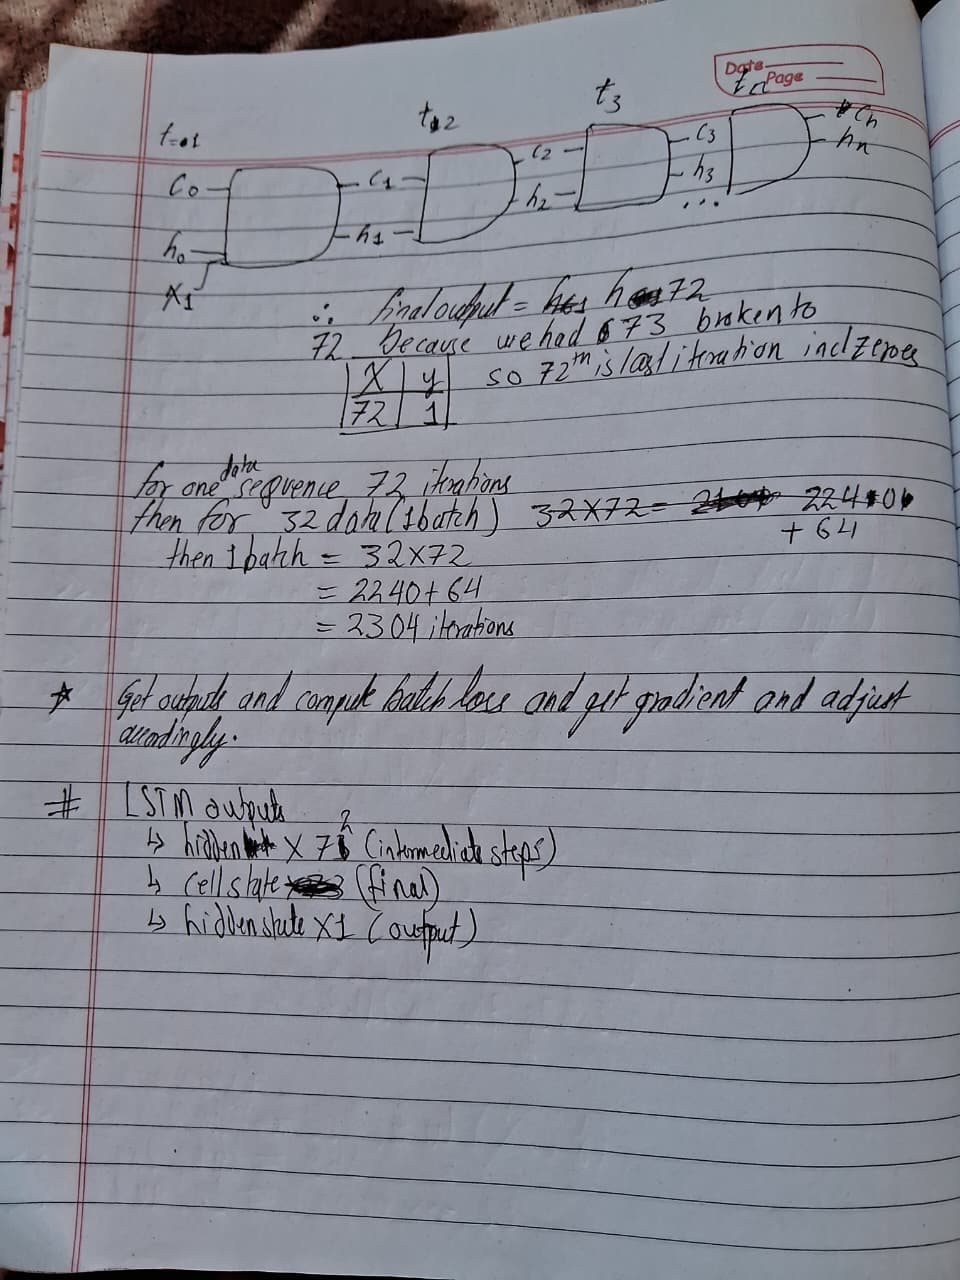

In [1]:
!pip install nltk

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
import nltk
import pickle

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shres\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shres\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
# Load Lyrics text instead of the long FAQ document
with open('lyric_dataset.txt', 'r', encoding='utf-8') as f:
    document = f.read().lower()

print(f"Loaded {len(document):,} characters")

Loaded 6,212 characters


In [3]:
# Tokenization
tokens = word_tokenize(document)

# Build vocab
vocab = {'<unk>': 0}
for token in Counter(tokens).keys():
    if token not in vocab:
        vocab[token] = len(vocab)

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 425


In [4]:
def text_to_indices(sentence_tokens, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in sentence_tokens]

input_sentences = document.split('\n')
input_numerical_sentences = []

for sentence in input_sentences:
    tokens = word_tokenize(sentence)
    if tokens:
        input_numerical_sentences.append(text_to_indices(tokens, vocab))

print(f"Number of sentences: {len(input_numerical_sentences)}")

Number of sentences: 174


In [5]:
training_sequence = []
for sentence in input_numerical_sentences:
    for i in range(1, len(sentence)):
        training_sequence.append(sentence[:i+1])

print(f"Total training sequences: {len(training_sequence)}")

Total training sequences: 1124


In [6]:
max_len = max(len(seq) for seq in training_sequence)
print(f"Max sequence length: {max_len}")

padded_training_sequence = []
for sequence in training_sequence:
    padded_training_sequence.append([0] * (max_len - len(sequence)) + sequence)

padded_training_sequence = torch.tensor(padded_training_sequence, dtype=torch.long)

X = padded_training_sequence[:, :-1]
y = padded_training_sequence[:, -1]

print(f"X shape: {X.shape}, y shape: {y.shape}")

Max sequence length: 16
X shape: torch.Size([1124, 15]), y shape: torch.Size([1124])


In [7]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = CustomDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 100)
        self.lstm = nn.LSTM(100, 150, batch_first=True)
        self.fc = nn.Linear(150, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (final_hidden_state, _) = self.lstm(embedded)
        output = self.fc(final_hidden_state.squeeze(0))
        return output

model = LSTMModel(len(vocab))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.009)

In [9]:
# Training loop - exactly like yours
epochs = 50

for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch: {epoch + 1}, Loss: {total_loss:.4f}")

Epoch: 1, Loss: 192.7133
Epoch: 2, Loss: 124.8290
Epoch: 3, Loss: 71.5072
Epoch: 4, Loss: 34.4018
Epoch: 5, Loss: 20.5797
Epoch: 6, Loss: 11.6051
Epoch: 7, Loss: 9.4257
Epoch: 8, Loss: 7.4944
Epoch: 9, Loss: 6.8422
Epoch: 10, Loss: 6.1402
Epoch: 11, Loss: 5.8954
Epoch: 12, Loss: 6.1116
Epoch: 13, Loss: 6.1550
Epoch: 14, Loss: 5.8248
Epoch: 15, Loss: 5.6129
Epoch: 16, Loss: 5.5453
Epoch: 17, Loss: 5.8046
Epoch: 18, Loss: 5.2300
Epoch: 19, Loss: 5.2380
Epoch: 20, Loss: 5.1332
Epoch: 21, Loss: 5.2834
Epoch: 22, Loss: 5.3581
Epoch: 23, Loss: 6.2323
Epoch: 24, Loss: 5.7979
Epoch: 25, Loss: 6.2206
Epoch: 26, Loss: 5.5764
Epoch: 27, Loss: 5.3701
Epoch: 28, Loss: 5.4887
Epoch: 29, Loss: 5.4561
Epoch: 30, Loss: 5.1896
Epoch: 31, Loss: 5.3351
Epoch: 32, Loss: 4.9290
Epoch: 33, Loss: 4.9498
Epoch: 34, Loss: 4.9003
Epoch: 35, Loss: 5.7074
Epoch: 36, Loss: 5.2895
Epoch: 37, Loss: 6.1285
Epoch: 38, Loss: 5.9729
Epoch: 39, Loss: 6.1687
Epoch: 40, Loss: 5.5333
Epoch: 41, Loss: 5.2045
Epoch: 42, Loss: 

In [10]:
# Same prediction function as yours
def prediction(model, vocab, text, max_len):
    model.eval()
    tokenized_text = word_tokenize(text.lower())
    numerical_text = [vocab.get(t, vocab['<unk>']) for t in tokenized_text]
    padded_text = torch.tensor([0] * (max_len - len(numerical_text)) + numerical_text, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(padded_text)
    
    _, index = torch.max(output, dim=1)
    predicted_word = list(vocab.keys())[list(vocab.values()).index(index.item())]
    
    return text + " " + predicted_word

# Test
print(prediction(model, vocab, "to be or not to", max_len))

to be or not to the


In [15]:
# Generate 10 words - exactly like your original loop
import time
num_tokens = 27
input_text = "Sticks and stones might break my bones but i dontcare what ya say cause im MR. 305  "

for i in range(num_tokens):
    output_text = prediction(model, vocab, input_text, max_len)
    print(output_text)
    input_text = output_text
    time.sleep(0.5)

Sticks and stones might break my bones but i dontcare what ya say cause im MR. 305   i
Sticks and stones might break my bones but i dontcare what ya say cause im MR. 305   i 'm
Sticks and stones might break my bones but i dontcare what ya say cause im MR. 305   i 'm so
Sticks and stones might break my bones but i dontcare what ya say cause im MR. 305   i 'm so low
Sticks and stones might break my bones but i dontcare what ya say cause im MR. 305   i 'm so low that
Sticks and stones might break my bones but i dontcare what ya say cause im MR. 305   i 'm so low that my
Sticks and stones might break my bones but i dontcare what ya say cause im MR. 305   i 'm so low that my scrotum
Sticks and stones might break my bones but i dontcare what ya say cause im MR. 305   i 'm so low that my scrotum 's
Sticks and stones might break my bones but i dontcare what ya say cause im MR. 305   i 'm so low that my scrotum 's almost
Sticks and stones might break my bones but i dontcare what ya say cause im

In [12]:
# SAVE MODEL + VOCAB + MAX_LEN as .pkl (for FastAPI / Streamlit)
save_dict = {
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'max_len': max_len,
    'vocab_size': len(vocab)
}

with open('lyrics_lstm_model.pkl', 'wb') as f:
    pickle.dump(save_dict, f)

print("Model saved as 'Lyrics_lstm_model.pkl' - Ready for deployment!")

Model saved as 'Lyrics_lstm_model.pkl' - Ready for deployment!
